In [16]:
import matplotlib.pyplot as plt
import math

In [1]:
from base import *
from game import *
from rules import *
from sim import *

In [32]:
mg = MultilinearGame(np.random.rand(2,3,3))
learner = OptimisticGradient(0.01, proj_sim)
sim = GameSim(mg, learner, ["swap", None])

In [47]:
sim.play(10000)

In [48]:
regrets = sim.regret_recorders["swap"]()

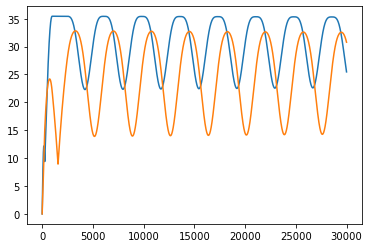

In [49]:
plt.plot([(i + 1) for i in range(regrets.shape[1])], regrets.transpose())

In [45]:
mg.weight

array([[[0.92020028, 0.5182174 , 0.05043156],
        [0.68146854, 0.62911783, 0.98555192],
        [0.9473983 , 0.1248528 , 0.87534935]],

       [[0.45595786, 0.5005482 , 0.72572855],
        [0.99928271, 0.68630738, 0.75402652],
        [0.49618762, 0.24821458, 0.55056519]]])